In [3]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench201'

In [4]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [5]:
dataset = 'cifar10'
data = dfs[dataset]

In [6]:
import json
with open('meta.json', 'r') as f:
    meta = json.load(f)
nb201_unique = [v['nb201-string'] for k, v in meta['ids'].items() if k == v['isomorph']]
nb201_unique[0]

'|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|'

In [7]:
from zc_combine.features.conversions import keep_only_isomorpic_nb201

data = keep_only_isomorpic_nb201(data, meta)

In [8]:
from zc_combine.fixes.operations import get_ops_edges_nb201
from zc_combine.fixes.utils import nb201_zero_out_unreachable

_, edge_map = get_ops_edges_nb201()
nb201_zero_out_unreachable(data, edge_map)

In [9]:
print(len(data))
data = data[data['net'] == data['new_net']]
print(len(data))

6466
6144


In [10]:
from zc_combine.features.conversions import nb201_to_graph

nets = {i: nb201_to_graph(data.loc[i]) for i in data.index}

In [11]:
import json

with open('../zc_combine/configs/nb201_first.json', 'r') as f:
    cfg = json.load(f)

In [12]:
from zc_combine.features.nasbench201 import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'op_on_position', 'min_path_len', 'max_op_on_path', 'node_degree'])

In [13]:
features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[1],"min_path_len_banned_[0, 1]","min_path_len_banned_[0, 1, 4]","min_path_len_banned_[1, 4]",max_op_on_path_allowed_[0],...,"node_degree_allowed_[0, 2]_avg_out","node_degree_allowed_[0, 3]_in_degree","node_degree_allowed_[0, 3]_out_degree","node_degree_allowed_[0, 3]_avg_in","node_degree_allowed_[0, 3]_avg_out","node_degree_allowed_[0, 2, 3]_in_degree","node_degree_allowed_[0, 2, 3]_out_degree","node_degree_allowed_[0, 2, 3]_avg_in","node_degree_allowed_[0, 2, 3]_avg_out",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,2,2,1,1,1,1,2,...,0.25,2,2,0.75,0.75,2,2,0.75,0.75,84.99
1,2,0,2,1,1,1,2,2,1,2,...,1.00,1,2,0.75,0.75,2,3,1.25,1.25,90.52
3,2,1,2,1,0,1,1,1,1,2,...,1.00,2,1,0.75,0.75,3,3,1.25,1.25,88.32
7,0,1,0,4,1,1,1,1,1,0,...,0.00,1,3,1.00,1.00,1,3,1.00,1.00,87.35
8,0,1,2,3,0,1,1,1,1,0,...,0.50,1,1,0.75,0.75,2,3,1.25,1.25,88.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,1,1,2,1,1,1,1,2,2,2,...,0.75,0,2,0.50,0.50,1,2,1.00,1.00,88.29
15618,2,0,2,1,1,1,1,1,1,2,...,1.00,1,2,0.75,0.75,3,3,1.25,1.25,88.56
15620,1,1,1,1,2,2,2,5,2,2,...,0.50,0,2,0.50,0.50,1,2,0.75,0.75,85.59


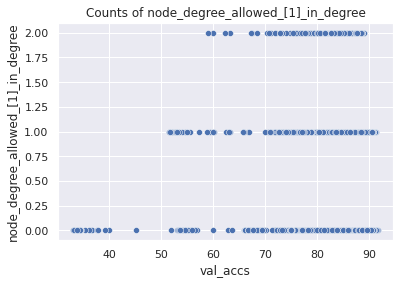

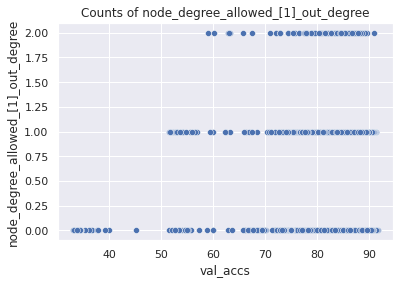

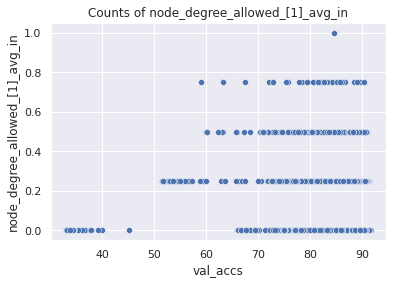

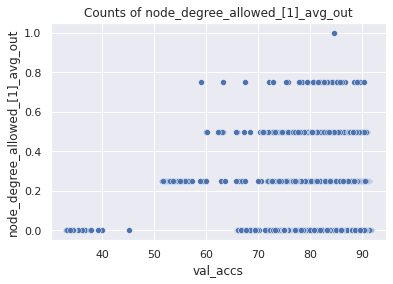

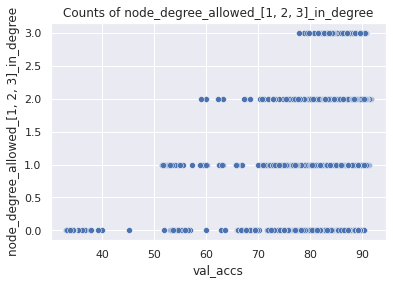

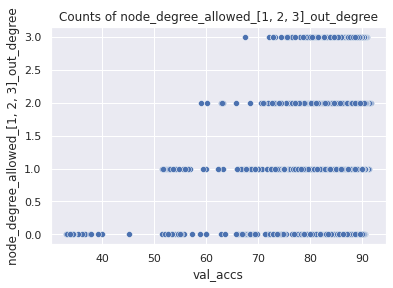

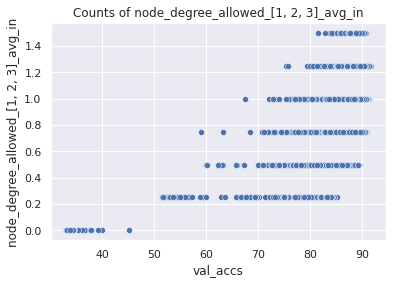

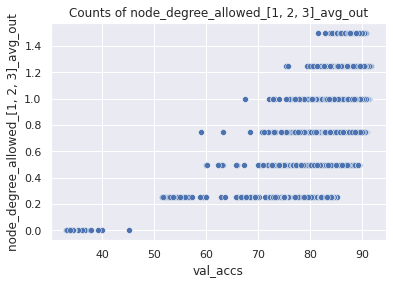

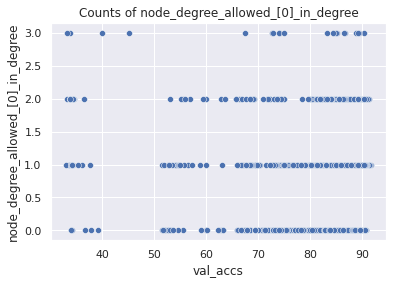

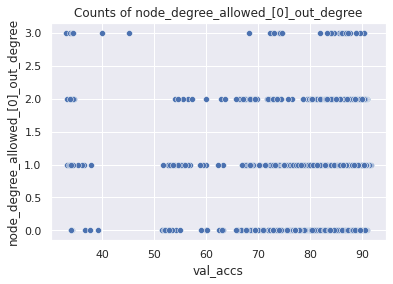

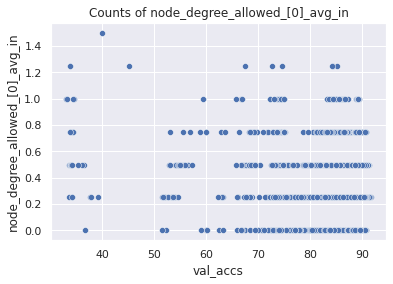

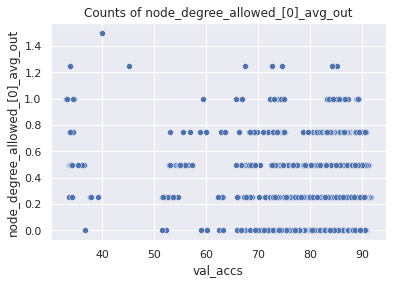

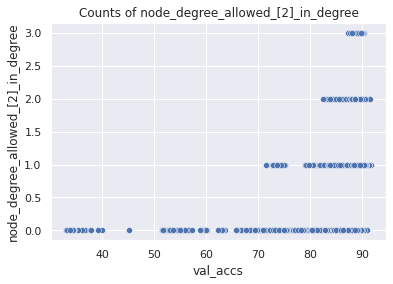

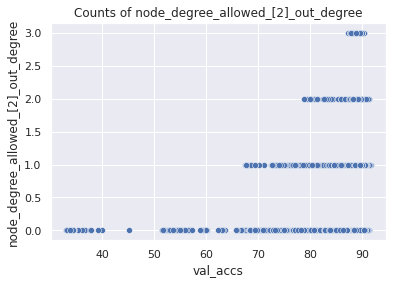

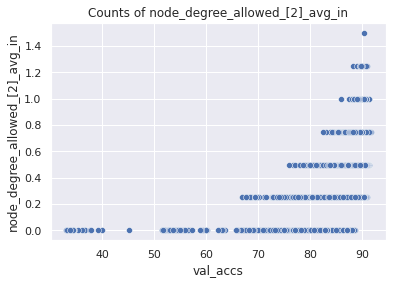

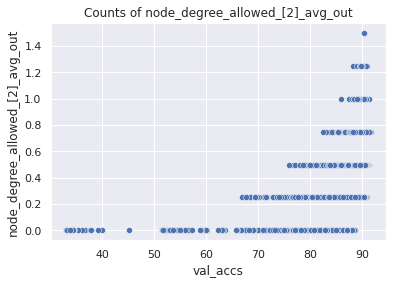

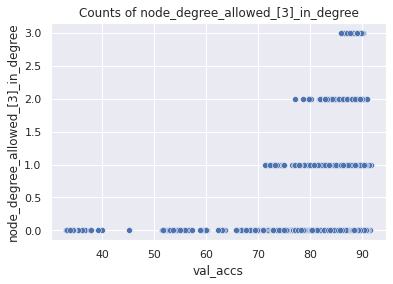

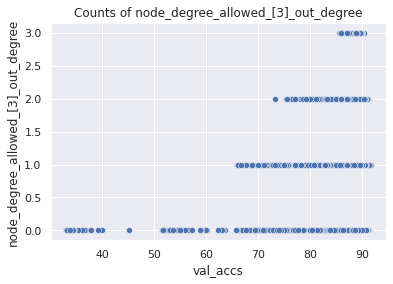

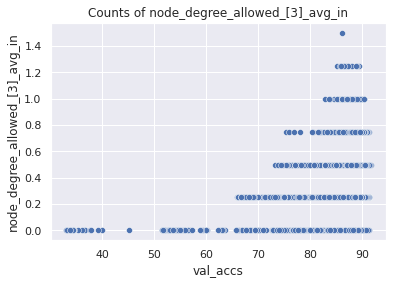

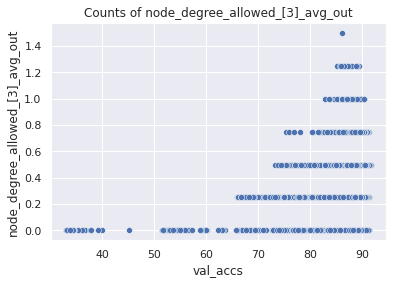

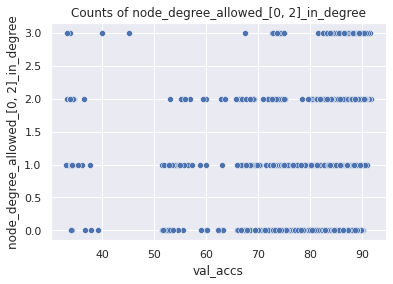

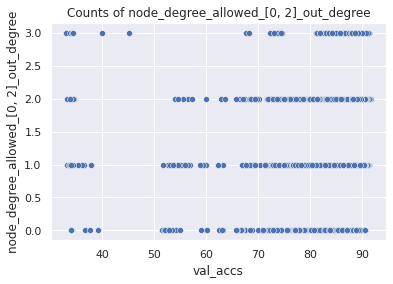

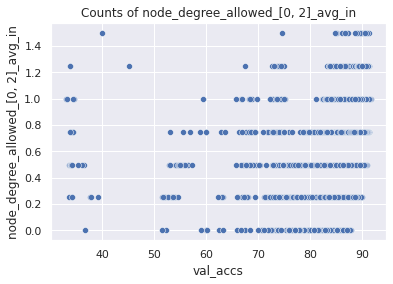

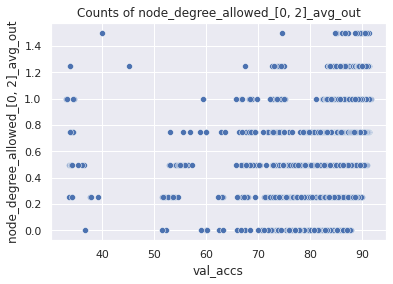

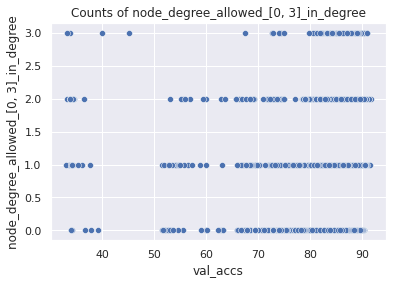

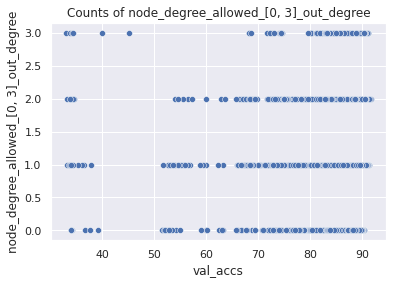

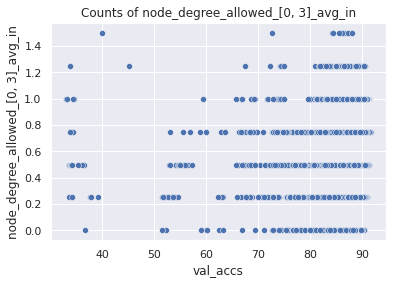

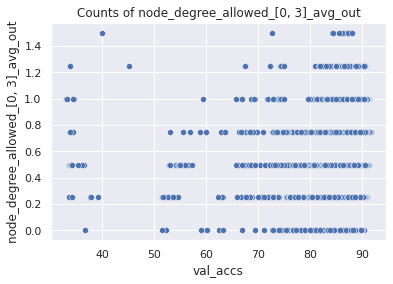

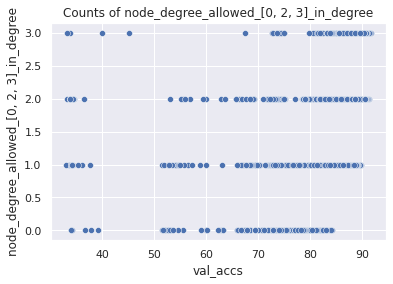

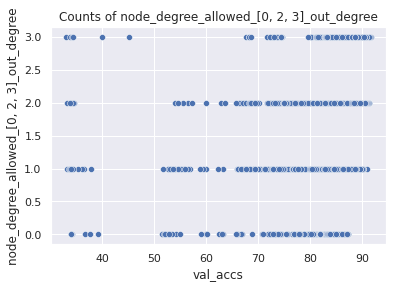

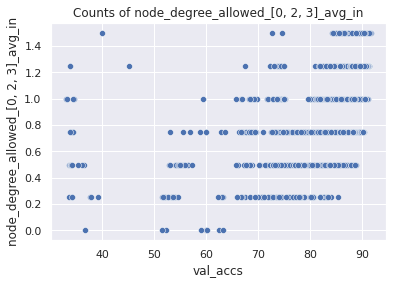

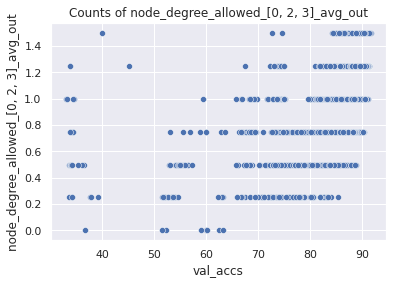

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['node_degree'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

for c in plot_df.columns:
    if c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [15]:
edges = list(edge_map.keys())

dataset_raw = {i: [n[1][e] for e in edges] for i, n in nets.items()}
dataset_raw[0]

[4, 0, 3, 1, 4, 3]

In [16]:
draw = [{'idx': i, **{f'op_{j}': v for j, v in enumerate(o)}} for i, o in dataset_raw.items()]
draw = pd.DataFrame(draw).set_index('idx')

In [17]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(6144, 50)


,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[1],"min_path_len_banned_[0, 1]","min_path_len_banned_[0, 1, 4]","min_path_len_banned_[1, 4]",max_op_on_path_allowed_[0],...,"node_degree_allowed_[0, 3]_in_degree","node_degree_allowed_[0, 3]_out_degree","node_degree_allowed_[0, 3]_avg_in","node_degree_allowed_[0, 3]_avg_out","node_degree_allowed_[0, 2, 3]_in_degree","node_degree_allowed_[0, 2, 3]_out_degree","node_degree_allowed_[0, 2, 3]_avg_in","node_degree_allowed_[0, 2, 3]_avg_out",flops,params
0,1,1,0,2,2,1,1,1,1,2,...,2,2,0.75,0.75,2,2,0.75,0.75,19.248832,0.129306
1,2,0,2,1,1,1,2,2,1,2,...,1,2,0.75,0.75,2,3,1.25,1.25,85.235392,0.587386
3,2,1,2,1,0,1,1,1,1,2,...,2,1,0.75,0.75,3,3,1.25,1.25,83.945152,0.587386
7,0,1,0,4,1,1,1,1,1,0,...,1,3,1.00,1.00,1,3,1.00,1.00,26.683072,0.185306
8,0,1,2,3,0,1,1,1,1,0,...,1,1,0.75,0.75,2,3,1.25,1.25,92.669632,0.643386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,1,1,2,1,1,1,1,2,2,2,...,0,2,0.50,0.50,1,2,1.00,1.00,85.235392,0.587386
15618,2,0,2,1,1,1,1,1,1,2,...,1,2,0.75,0.75,3,3,1.25,1.25,85.235392,0.587386
15620,1,1,1,1,2,2,2,5,2,2,...,0,2,0.50,0.50,1,2,0.75,0.75,50.706112,0.344346
15622,0,0,2,3,1,1,1,1,1,0,...,2,1,0.75,0.75,3,2,1.25,1.25,93.959872,0.643386


In [18]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, random_state=43):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        rf = RandomForestRegressor(random_state=random_state + i, n_estimators=100)
        rf.fit(trx, tryy)
        res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [19]:
import numpy as np

skip_dis = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    if skip_dis:
        break

    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

In [26]:
ts = 100
seed = 45

all_proxies = False
prox_to_include = []
prox_to_include = ['jacov', 'fisher']
with_features = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.6693093300026755, tau: 0.7737745740586615, corr: 0.9275874688124599


array([85.1152, 90.1024, 89.2142, ..., 81.1865, 88.8346, 86.2696])

In [ ]:
trainpreds = rf_fitted.predict(train_X)

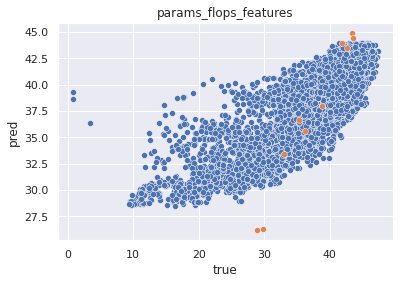

In [115]:
sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(plt_name)
#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

In [162]:
from sklearn.decomposition import PCA

pca_data = fd#data[proxy_cols]
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data)
pca_data

array([[-1381.62666317,   -12.83859515],
       [-1390.83665134,     4.72293304],
       [-1390.81339521,     3.95582105],
       ...,
       [-1340.03601862,    -4.7643099 ],
       [-1391.14828775,     6.71255883],
       [-1381.92952336,    -5.30844093]])

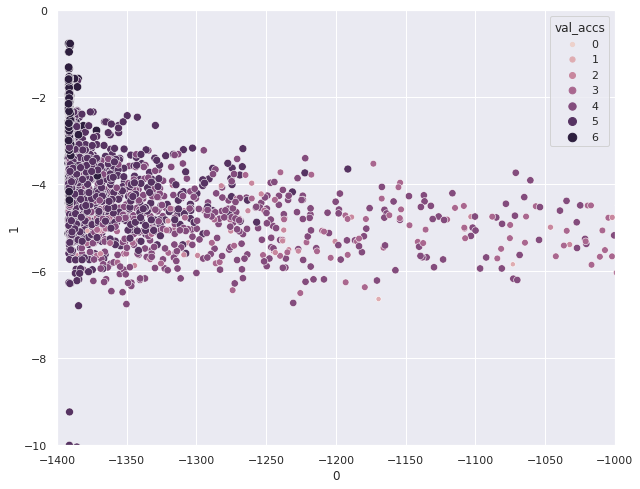

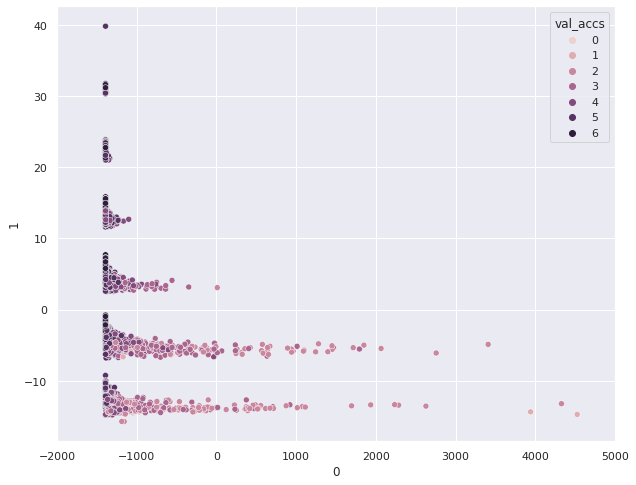

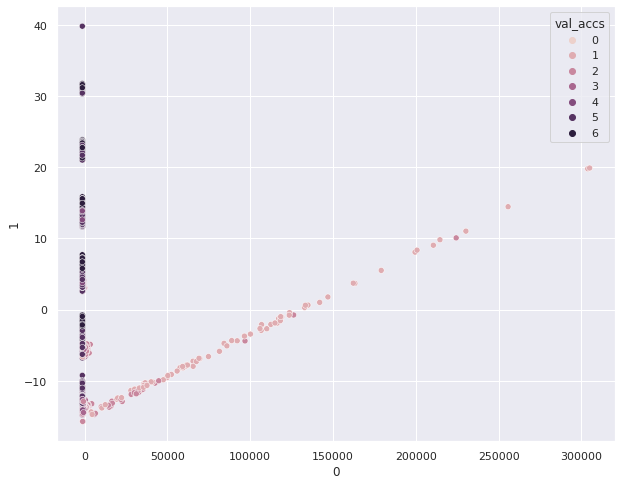

In [169]:
val_accss = data['val_accs'].to_numpy()
plot_dd = pd.DataFrame(pca_data)
plot_dd['val_accs'] = val_accss // 7


plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs', size='val_accs')
plt.xlim(-1400, -1000)
#plt.xlim(-1392, -1387)
plt.ylim(-10, 0)
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
plt.xlim(-2000, 5000)
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
#plt.xlim(-2000, 5000)
plt.show()

In [123]:
imps = rf_fitted.feature_importances_

pd.DataFrame({"importance": imps, "feat": fd.columns})

,importance,feat
0,0.001087,op_count_0
1,0.000708,op_count_1
2,0.001233,op_count_2
3,0.000649,op_count_3
4,0.005573,op_count_4
5,0.005445,min_path_len_banned_[1]
6,0.002757,"min_path_len_banned_[0, 1]"
7,0.001153,"min_path_len_banned_[0, 1, 4]"
8,0.366465,"min_path_len_banned_[1, 4]"
9,0.003172,max_op_on_path_allowed_[0]


In [124]:
# IDEA ... sample different nets based on clustering (max distance between nets...)

In [125]:
pd.DataFrame({'pred': preds, 'true': y, 'net': data['net']})

NameError: name 'y' is not defined

In [ ]:
from scipy.stats import kendalltau, spearmanr

kendalltau(preds, dsy)[0], spearmanr(preds, dsy)[0]

In [757]:
# TODO ruzny pocty siti
# where to sample... important
# TODO predikovat pres proxyny

# TODO vyplot predikci jen pres flops/params
# ... try that on transnb101

In [ ]:
#Next steps:

# TODO lepsi nazvy sloupecku, to str
# TODO fce co to spocita a da do df (myslim ty edge_path_op atd)
# TODO predikce - pres ruzny seedy, mozna crossval
# TODO porovnani s proxynama a bez, xgboost,...
# TODO tnb101

# TODO ruzny dalsi features...